Generate encoded vectors for both query and artist aggregrate images

In [1]:
import read_rijksdata
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa 

import matplotlib.pylab as plt
import matplotlib as mpl
MIN_NUM_ARTWORK = 500


/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# LOAD IMAGE AND LABELS HERE
# replace for your path here!
img_folder = '/Users/erebor/Downloads/out_img'

images, labels_onehot, labels, names, = read_rijksdata.load_data(MIN_NUM_ARTWORK=MIN_NUM_ARTWORK,
                                                 img_folder = img_folder,
                                                 labels_file ='labels.txt',
                                                 names_file = 'names.txt')

/Users/erebor/repos/ML_Rijksmuseum/read_rijksdata.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names = pd.read_csv(names_file,delimiter = '/t',header=None)


 |███████████████████████████████████████-| 112038/112039 

Dataset loaded!
images shape:	 (19007, 56, 56, 3)
labels shape:	 (19007,)
labels (one-hot): (19007, 21)
names shape:	 (19007, 1)


In [3]:
classes = len(list(set(labels)))
print('\n# of unique artists:',classes)

counts = pd.DataFrame(labels).value_counts()
print('Min # of artworks for all artists:',min(counts))
print('Min # of artworks specified:',MIN_NUM_ARTWORK)


# of unique artists: 21
Min # of artworks for all artists: 517
Min # of artworks specified: 500


In [4]:
# LOAD PRE-TRAINED ENCODER
# get base pre-trained model first
# more models are available here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

# define hyperparameters
# define image size 
input_shape = (56,56,3)
vector_length = 50
# define number of classes
# ****THIS sets the number of dimensions of the encoded vector ("D") in Mark's email***
# we'll probably want adjust this to be smaller or larger (depending on training results)
# for now, classes are just the number of unique artist
base_kwargs = {'include_top':False,
               'weights':'imagenet',
               'input_shape':input_shape,
               'pooling':None,
               'classes':vector_length}
#enet_base = tf.keras.applications.efficientnet.EfficientNetB7(**enet_kwargs)
base = tf.keras.applications.vgg19.VGG19(**base_kwargs)

# set that the encoder DOES NOT train on the images
base.trainable = True

# set pre-trained model as base
encoder = tf.keras.models.Sequential()
encoder.add(base)

# add two final top layers
#encoder.add(tf.keras.layers.GlobalMaxPooling2D())
encoder.add(tf.keras.layers.GlobalMaxPooling2D())
#encoder.add(tf.keras.layers.Dropout(rate=0.01))

encoder.add(tf.keras.layers.Dense(vector_length, activation="sigmoid")) # last (top) layer of network

In [5]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                25650     
Total params: 20,050,034
Trainable params: 20,050,034
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Create encoded tensors for all 
vectors = encoder.predict(images,verbose=1)

594/594 [==============================] - 262s 441ms/step


In [7]:
vectors

array([[7.38985062e-01, 9.67605710e-01, 1.14142924e-04, ...,
        3.49678412e-05, 2.17523993e-05, 9.33070064e-01],
       [1.10764165e-09, 1.31022274e-01, 2.94408073e-06, ...,
        6.82371001e-06, 7.25090959e-11, 9.99504626e-01],
       [4.80270728e-07, 1.19651791e-04, 3.18034381e-07, ...,
        5.97651342e-05, 2.63242214e-07, 1.00000000e+00],
       ...,
       [1.67693942e-10, 2.68188119e-02, 3.34644596e-08, ...,
        3.27867456e-05, 5.02599903e-07, 1.00000000e+00],
       [3.30669877e-06, 1.18252050e-04, 4.51049510e-11, ...,
        7.22418463e-07, 1.02207805e-10, 9.99990940e-01],
       [1.00186604e-04, 9.95706677e-01, 1.09486784e-07, ...,
        2.74399536e-05, 9.99694884e-01, 1.67404711e-02]], dtype=float32)

In [8]:
def plot_images(images,artistname):

    # plot a selection of 25 (5x5) artwork
    fig, axes = plt.subplots(figsize=(10,10),nrows=5,ncols=5)
    fig.patch.set_facecolor('white')

    i = 0 
    for ax in axes.reshape(-1): 
        ax.imshow(images[i,:,:,:])
        ax.set_xticks([]),ax.set_yticks([])
        i +=1
    plt.suptitle('Artist: {}'.format(artistname),fontsize=15)
    fig.subplots_adjust(top=0.9)
    plt.savefig('figs/samples/artist_{}.png'.format(artistname[0].replace(',','-').replace(' ','-')),dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

In [9]:
# Create aggregate vectors
# Count how many pieces each artist has
total_bc = np.bincount(labels) # get count of artists
artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
artistnames = names[np.unique(labels)] # get the name for each unique artist

aggregate_vectors = []
for i in range(len(artcounts)):
    artistnum = np.unique(labels)[i] #Gets the number that represents this artist from labels
    artistname = artistnames[i]
    artcount = artcounts[i] #Gets number of art pieces by this artist
    
    neg_idx = np.where(labels != artistnum) 
    pos_idx = np.where(labels == artistnum)
    artist_vector = np.mean(vectors[pos_idx],axis=0)
    
    query_images = images[neg_idx]
    query_vectors = vectors[neg_idx]
    
    aggregate_vectors.append(artist_vector)

    #x = np.expand_dims(vectors[pos_idx].T,axis=2)
    #artist_vector = pool_layer(x).numpy()
    #aggregate_vectors.append(artist_vector.reshape(50,))
      
aggregate_vectors = np.array(aggregate_vectors)

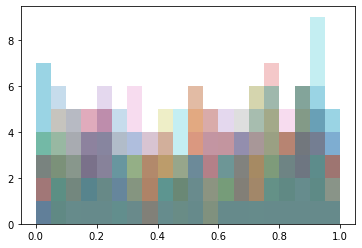

In [10]:
plt.figure()
bins = np.arange(0,1.1,0.05)
for vector in aggregate_vectors:
    plt.hist(vector,bins=bins,alpha=0.25,histtype='bar')
plt.xlim(-0.05,1.05)
plt.show()
plt.title('Aggregrate Vectors Distributions')
plt.close()

In [11]:
def plot_aggregates(aggregate_vectors,artistnames,n=3):
    idx = list(range(aggregate_vectors.shape[0]))
    idxs = np.random.choice(a=idx,size=n*n)
    vectors = aggregate_vectors[idxs]
    artists = artistnames[idxs]
    
    fig, axes = plt.subplots(nrows=n,ncols=n,figsize=(9,5))
    for ax_idx, ax in enumerate(fig.axes):
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        ax.imshow(np.atleast_2d(vectors[ax_idx]), aspect=7, cmap='rainbow', interpolation=None,norm=norm)
        ax.set_xticks([]),ax.set_yticks([])
        ax.set_xlabel(artists[ax_idx][0])
    plt.savefig('figs/aggregrates_sample_trained.png',dpi=200,tight_layout=True)
    plt.show()
    plt.close()

<ipython-input-11-4c977d2a8d23>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figs/aggregrates_sample_trained.png',dpi=200,tight_layout=True)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 26 missing from current font.
  font.set_text(s, 0, flags=flags)


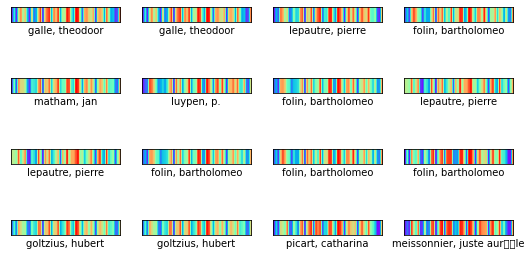

In [12]:
plot_aggregates(aggregate_vectors,artistnames,n=4)

In [13]:
# Query Image Removal Function
def query_image_remover(qi_vec, avg_vec, artnum):
    new_vec = (tf.math.subtract(avg_vec,  qi_vec * (1/artnum)) * (artnum/(artnum-1)))
    return new_vec

In [14]:
def load_vectors(vectors, names, labels, NUM_EXAMPLE = 20, train_val_split=0.8):
    """
    purpose: load dataset of query and aggregrate vector pairs and binary label indicating same artist among the pair
        - label for each pair should be 1 if query vector and aggregrate vector belong to same artist, 0 if not
        - any query vector that DOES belong to the artist should be subracted from aggregrate vector
        - train, development, and validation are exclusive (no query image appear more than once)

    arguments: 
        vectors (numpy matrix)    : all vectors that were encoded from images of original dataset
        names  (list of strings)  : string for name of artist
        labels (list of integers) : integer index of artist
        NUM_EXAMPLE (integer)     : number of positive and negative pairs to create 
                                    e.g. total number of examples per artist is 2 * NUM_EXAMPLE
                                    NUM_EXAMPLE should NOT be greater than MIN_NUM_ARTWORK
    
    returns:
        train_pairs  : (batch, vector_length, 2) aggregrate and query image pairs for training
        train_labels : (batch, )                 labels (0 or 1) indicating artist match for training
        dev_pairs    : (batch, vector_length, 2) aggregrate and query image pairs for development
        dev_labels   : (batch, )                 labels (0 or 1) indicating artist match for development
        val_pairs    : (batch, vector_length, 2) aggregrate and query image pairs for validation
        val_labels   : (batch, )                 labels (0 or 1) indicating artist match for validation
    """
    total_bc = np.bincount(labels) # get count of artists
    artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
    artistnames = names[np.unique(labels)] # get the name for each unique artist
    
    aggregate_vectors = []
    query_vectors = []
    used_query_idx = []
    
    # iterate through each artist
    for i in range(len(artcounts)):
        artistnum = np.unique(labels)[i] # Gets the number that represents this artist from labels
        artistname = artistnames[i] # Gets artist name as string
        artcount = artcounts[i] # Gets number of art pieces by this artist

        # get indicies of artist's artwork
        pos_idx = np.where(labels == artistnum)
        
        # get indicies that are not artist's artwork
        neg_idx = np.where(labels != artistnum) 

        # get artwork vectors not belonging to artist
        potential_query_vectors = vectors[neg_idx]
        
        aggregate_vector = np.mean(vectors[pos_idx],axis=0)
        
        # store aggregrate vectors for each artist
        aggregate_vectors.append(artist_vector)

    aggregate_vectors = np.array(aggregate_vectors)

    return train_pairs, train_labels, dev_pairs, dev_labels, val_pairs, val_labels